1. Imports and Logger Setup

In [56]:
# Install Roboflow if not already installed
!pip install roboflow

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator
import os
import json
from datetime import datetime
import torch
from detectron2.utils.events import EventStorage
import logging
from collections import Counter

from roboflow import Roboflow

DEPRECATION: Loading egg at /home/rayhaan/.pyenv/versions/3.12.3/lib/python3.12/site-packages/detectron2-0.6-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


2. Roboflow Initialization

In [ ]:
# Initialize Roboflow with your API key
rf = Roboflow(api_key="Remove this before sharing")
project = rf.workspace("Removed").project("Removed")
version = project.version(1)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


3. Define Paths and Valid Categories

In [58]:
# Define paths
# Assuming Roboflow downloads the dataset into a directory like 'cavities-ppzqf_1'
DATASET_DIR = dataset.location  # This gets the path where Roboflow downloaded the dataset

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VALID_DIR = os.path.join(DATASET_DIR, "valid")
TRAIN_JSON = os.path.join(TRAIN_DIR, "_annotations.coco.json")
VALID_JSON = os.path.join(VALID_DIR, "_annotations.coco.json")

# Define valid categories
VALID_CATEGORIES = {
    "Carries": 0,
    "Fillings": 1,
    "tooth": 2
}

In [59]:
print(f"Dataset directory: {DATASET_DIR}")

Dataset directory: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Cavities-1


4. Data Cleaning and Remapping Annotations

In [60]:
def clean_and_remap_annotations(json_file):
    """Clean the JSON annotations to only include valid categories"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    new_categories = [
        {"id": idx, "name": name, "supercategory": "dental"} 
        for name, idx in VALID_CATEGORIES.items()
    ]
    
    new_annotations = []
    for ann in data['annotations']:
        category_name = next(
            (cat['name'] for cat in data['categories'] if cat['id'] == ann['category_id']), 
            None
        )
        if category_name in VALID_CATEGORIES:
            ann_copy = ann.copy()
            ann_copy['category_id'] = VALID_CATEGORIES[category_name]
            new_annotations.append(ann_copy)
    
    cleaned_data = {
        "info": data.get("info", {}),
        "licenses": data.get("licenses", []),
        "images": data.get("images", []),
        "categories": new_categories,
        "annotations": new_annotations
    }
    
    return cleaned_data

5. Convert Dataset to Detectron2 Format

In [61]:
def get_dental_dicts(img_dir, ann_file):
    """Convert dataset to Detectron2 format"""
    print(f"Loading and cleaning annotations from: {ann_file}")
    cleaned_data = clean_and_remap_annotations(ann_file)
    
    dataset_dicts = []
    for img in cleaned_data['images']:
        record = {}
        
        filename = os.path.join(img_dir, img['file_name'])
        if not os.path.exists(filename):
            print(f"Warning: Image not found: {filename}")
            continue
            
        record["file_name"] = filename
        record["image_id"] = img['id']
        record["height"] = img['height']
        record["width"] = img['width']
        
        annos = []
        for ann in cleaned_data['annotations']:
            if ann['image_id'] == img['id']:
                obj = {
                    "bbox": ann['bbox'],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": ann.get('segmentation', []),
                    "category_id": ann['category_id'],
                }
                annos.append(obj)
        record["annotations"] = annos
        dataset_dicts.append(record)
    
    print(f"Loaded {len(dataset_dicts)} images with valid annotations")
    return dataset_dicts

6. Custom Trainer with COCO Evaluator

In [62]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

7. Register Datasets with Detectron2

In [63]:
def register_datasets():
    """Register the datasets with Detectron2"""
    print("Registering datasets with cleaned categories...")
    
    for d in ["train", "val"]:
        dataset_name = f"cavities_{d}"
        if dataset_name in DatasetCatalog:
            DatasetCatalog.remove(dataset_name)
        if dataset_name in MetadataCatalog:
            MetadataCatalog.remove(dataset_name)
    
    for d in ["train", "val"]:
        DatasetCatalog.register(
            f"cavities_{d}", 
            lambda d=d: get_dental_dicts(
                TRAIN_DIR if d=="train" else VALID_DIR,
                TRAIN_JSON if d=="train" else VALID_JSON
            )
        )
        
        MetadataCatalog.get(f"cavities_{d}").set(
            thing_classes=list(VALID_CATEGORIES.keys()),
            thing_colors=[(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 
                         for _ in VALID_CATEGORIES]
        )
    
    print("\nRegistered categories:")
    for name, idx in VALID_CATEGORIES.items():
        print(f"ID: {idx}, Name: {name}")

8. Model Training Configuration and Execution

In [64]:
def train_model():
    """Train the model"""
    register_datasets()

    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("cavities_train",)
    cfg.DATASETS.TEST = ("cavities_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1000  # Adjust based on your dataset size
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(VALID_CATEGORIES)
    cfg.TEST.EVAL_PERIOD = 100  # Evaluate every 100 iterations

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    cfg.OUTPUT_DIR = f"./output_cavities_{timestamp}"
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    print(f"\nModel configuration:")
    print(f"Number of classes: {len(VALID_CATEGORIES)}")
    print(f"Output directory: {cfg.OUTPUT_DIR}")

    trainer = CustomTrainer(cfg)
    trainer.resume_or_load(resume=False)

    print("\nStarting training...")
    return trainer, cfg

9. Inference and Visualization Functions

In [65]:
def perform_inference(cfg, dataset_name):
    """Perform inference and visualize results"""
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set testing threshold
    predictor = DefaultPredictor(cfg)
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE_BW)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        plt.figure(figsize=(12, 8))
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()

def compare_ground_truth_and_predictions(dataset_name, predictor, num_samples=3):
    """Compare ground truth and predictions side by side"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    for d in random.sample(dataset_dicts, num_samples):
        img = cv2.imread(d["file_name"])
        
        # Ground truth visualization
        visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
        vis_gt = visualizer.draw_dataset_dict(d)
        
        # Prediction visualization
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1],
                      metadata=metadata, 
                      scale=0.8, 
                      instance_mode=ColorMode.IMAGE_BW)
        vis_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        combined_img = np.hstack((vis_gt.get_image()[:, :, ::-1], vis_pred.get_image()[:, :, ::-1]))
        
        plt.figure(figsize=(20, 10))
        plt.imshow(combined_img)
        plt.axis('off')
        plt.title("Ground Truth (left) vs Predictions (right)")
        plt.show()

def analyze_class_distribution(dataset_name, predictor):
    """Analyze class distribution"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    
    gt_distribution = Counter()
    pred_distribution = Counter()
    
    for d in dataset_dicts:
        # Ground truth distribution
        for ann in d["annotations"]:
            class_name = metadata.thing_classes[ann["category_id"]]
            gt_distribution[class_name] += 1
        
        # Predicted distribution
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        pred_classes = outputs["instances"].pred_classes.cpu().numpy()
        for class_id in pred_classes:
            class_name = metadata.thing_classes[class_id]
            pred_distribution[class_name] += 1
    
    # Plot distributions
    classes = list(set(list(gt_distribution.keys()) + list(pred_distribution.keys())))
    gt_counts = [gt_distribution[c] for c in classes]
    pred_counts = [pred_distribution[c] for c in classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(15, 7))
    rects1 = ax.bar(x - width/2, gt_counts, width, label='Ground Truth')
    rects2 = ax.bar(x + width/2, pred_counts, width, label='Predictions')
    
    ax.set_ylabel('Number of Instances')
    ax.set_title('Class Distribution: Ground Truth vs Predictions')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detection rates
    print("\nDetection Rates by Class:")
    print("-" * 50)
    for class_name in classes:
        gt = gt_distribution[class_name]
        pred = pred_distribution[class_name]
        if gt > 0:
            detection_rate = (pred / gt) * 100
            print(f"{class_name:20s}: {detection_rate:6.2f}% ({pred}/{gt})")

10. Confusion Matrix Calculation and Visualization

In [66]:
def calculate_confusion_matrix(dataset_name, predictor):
    """Calculate and visualize confusion matrix"""
    dataset_dicts = DatasetCatalog.get(dataset_name)
    metadata = MetadataCatalog.get(dataset_name)
    num_classes = len(metadata.thing_classes)
    
    confusion_matrix = np.zeros((num_classes, num_classes))
    
    for d in dataset_dicts:
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        
        pred_boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
        pred_classes = outputs["instances"].pred_classes.cpu().numpy()
        
        gt_boxes = np.array([ann["bbox"] for ann in d["annotations"]])
        gt_classes = np.array([ann["category_id"] for ann in d["annotations"]])
        
        for pred_idx, pred_box in enumerate(pred_boxes):
            if len(gt_boxes) > 0:
                ious = calculate_iou(pred_box, gt_boxes)
                max_iou_idx = np.argmax(ious)
                if ious[max_iou_idx] > 0.5:
                    confusion_matrix[gt_classes[max_iou_idx]][pred_classes[pred_idx]] += 1
    
    plt.figure(figsize=(12, 10))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    classes = metadata.thing_classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(int(confusion_matrix[i, j]), 'd'),
                     horizontalalignment="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def calculate_iou(box1, box2):
    """Calculate IoU between boxes"""
    box1 = np.array([box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]])
    box2 = np.array([[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in box2])
    
    x1 = np.maximum(box1[0], box2[:, 0])
    y1 = np.maximum(box1[1], box2[:, 1])
    x2 = np.minimum(box1[2], box2[:, 2])
    y2 = np.minimum(box1[3], box2[:, 3])
    
    intersection = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    union = box1_area + box2_area - intersection
    
    return intersection / union

11. Training Curves Plotting

In [67]:
def plot_training_curves(cfg):
    """Plot training curves"""
    metrics_file = os.path.join(cfg.OUTPUT_DIR, "metrics.json")
    
    iterations = []
    total_loss = []
    
    with open(metrics_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            if "total_loss" in data:
                iterations.append(data["iteration"])
                total_loss.append(data["total_loss"])
    
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, total_loss)
    plt.xlabel("Iterations")
    plt.ylabel("Total Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.show()

12. Main Execution Pipeline

Starting dental cavity detection pipeline...

Initiating model training...
Registering datasets with cleaned categories...

Registered categories:
ID: 0, Name: Carries
ID: 1, Name: Fillings
ID: 2, Name: tooth

Model configuration:
Number of classes: 3
Output directory: ./output_cavities_20241103_092951


[11/03 09:29:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 


Starting training...
[11/03 09:29:52 d2.engine.train_loop]: Starting training from iteration 0
[11/03 09:30:00 d2.utils.events]:  eta: 0:03:37  iter: 19  total_loss: 2.734  loss_cls: 1.455  loss_box_reg: 1.019  loss_rpn_cls: 0.2181  loss_rpn_loc: 0.04967    time: 0.3453  last_time: 0.1611  data_time: 0.0199  last_data_time: 0.0118   lr: 4.9953e-06  max_mem: 4304M
[11/03 09:30:05 d2.utils.events]:  eta: 0:03:03  iter: 39  total_loss: 2.806  loss_cls: 1.354  loss_box_reg: 1.008  loss_rpn_cls: 0.3178  loss_rpn_loc: 0.06522    time: 0.2823  last_time: 0.1658  data_time: 0.0150  last_data_time: 0.0051   lr: 9.9902e-06  max_mem: 4304M
[11/03 09:30:09 d2.utils.events]:  eta: 0:02:55  iter: 59  total_loss: 2.437  loss_cls: 1.155  loss_box_reg: 1.023  loss_rpn_cls: 0.1801  loss_rpn_loc: 0.04291    time: 0.2649  last_time: 0.2616  data_time: 0.0169  last_data_time: 0.0141   lr: 1.4985e-05  max_mem: 4304M
[11/03 09:30:13 d2.utils.events]:  eta: 0:02:48  iter: 79  total_loss: 2.178  loss_cls: 0.9

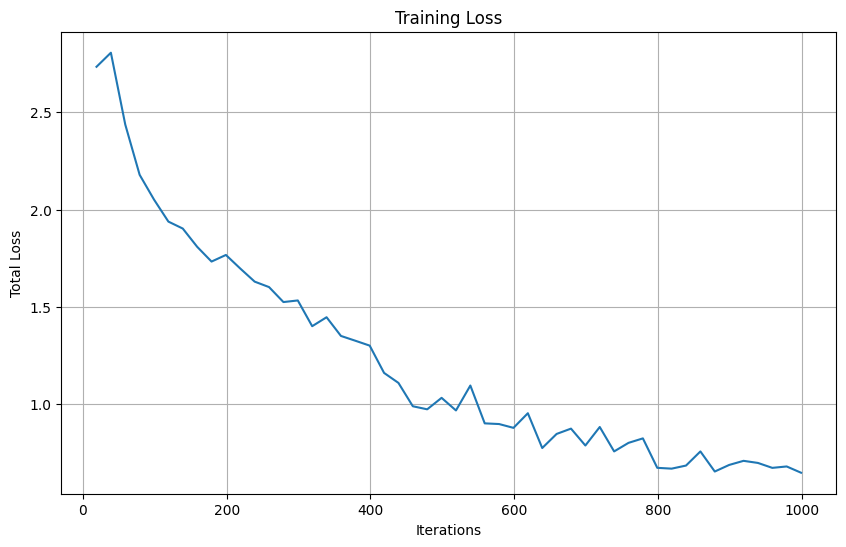


Visualizing inference results...
[11/03 09:33:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_cavities_20241103_092951/model_final.pth ...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Cavities-1/valid/_annotations.coco.json
Loaded 11 images with valid annotations


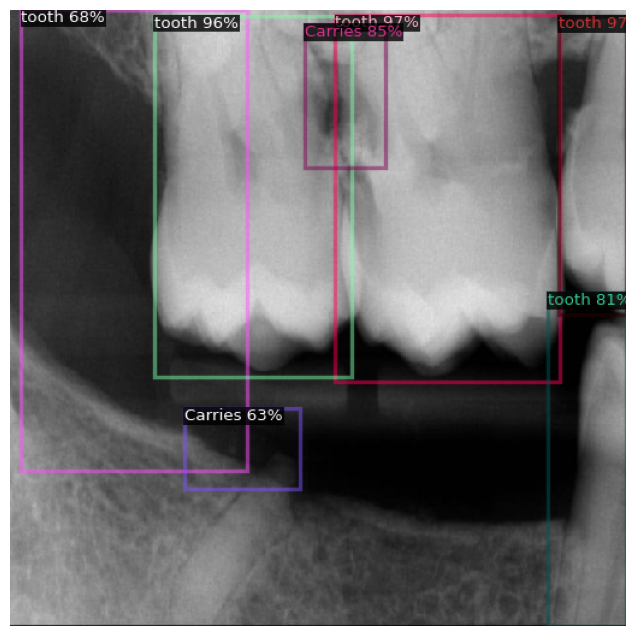

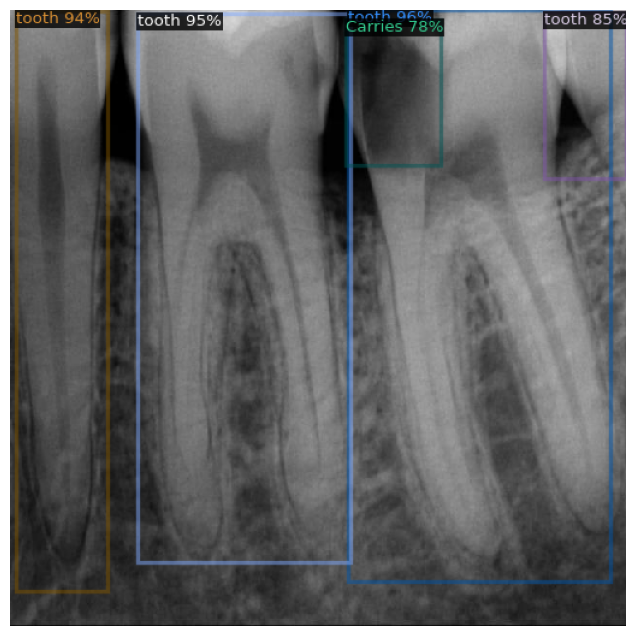

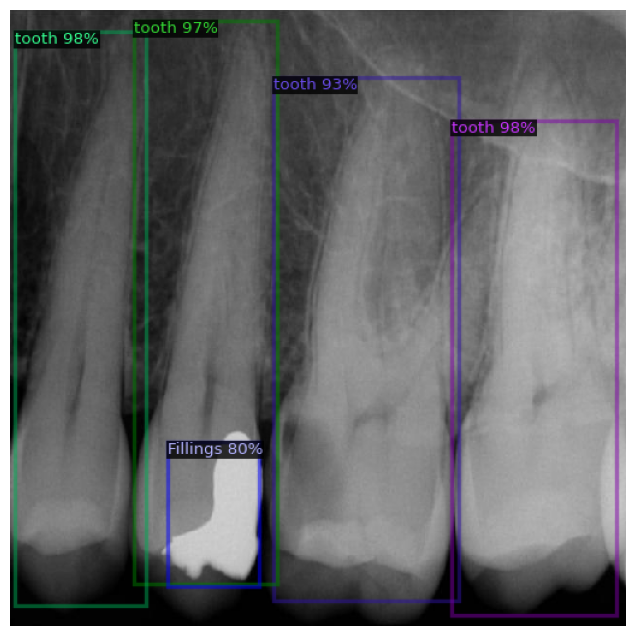


Comparing ground truth with predictions...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Cavities-1/valid/_annotations.coco.json
Loaded 11 images with valid annotations


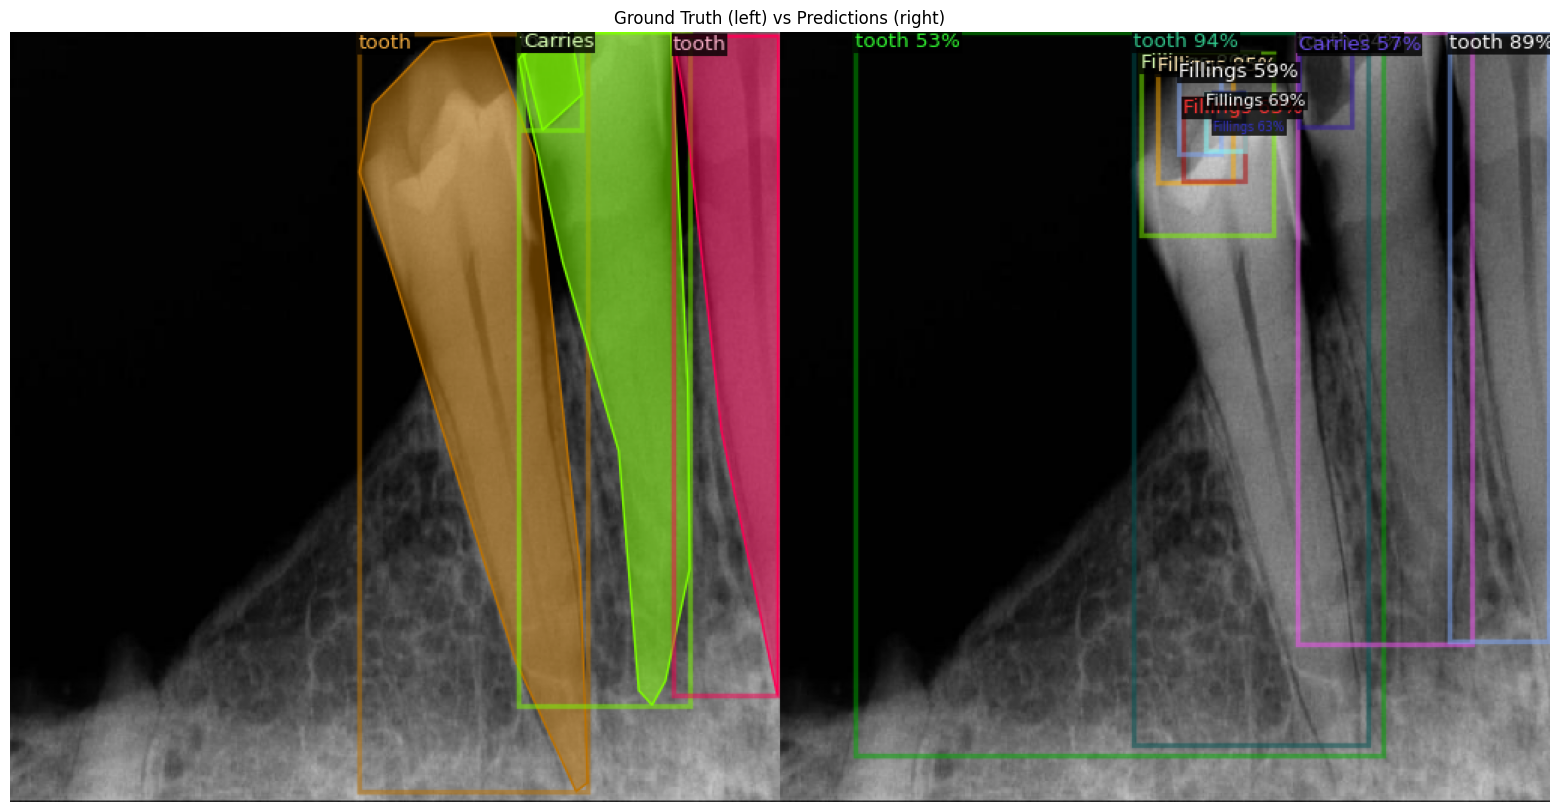

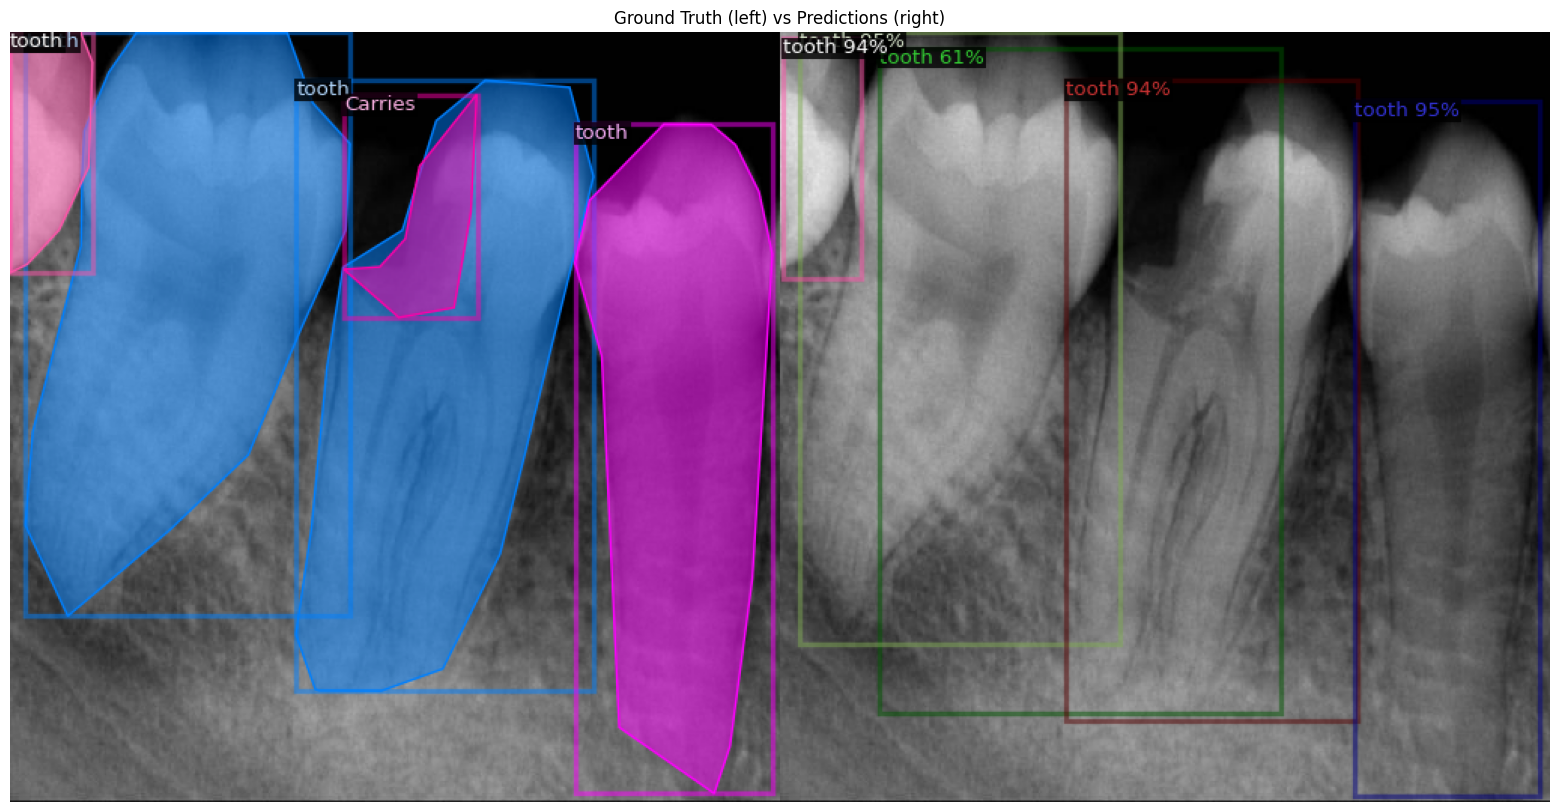

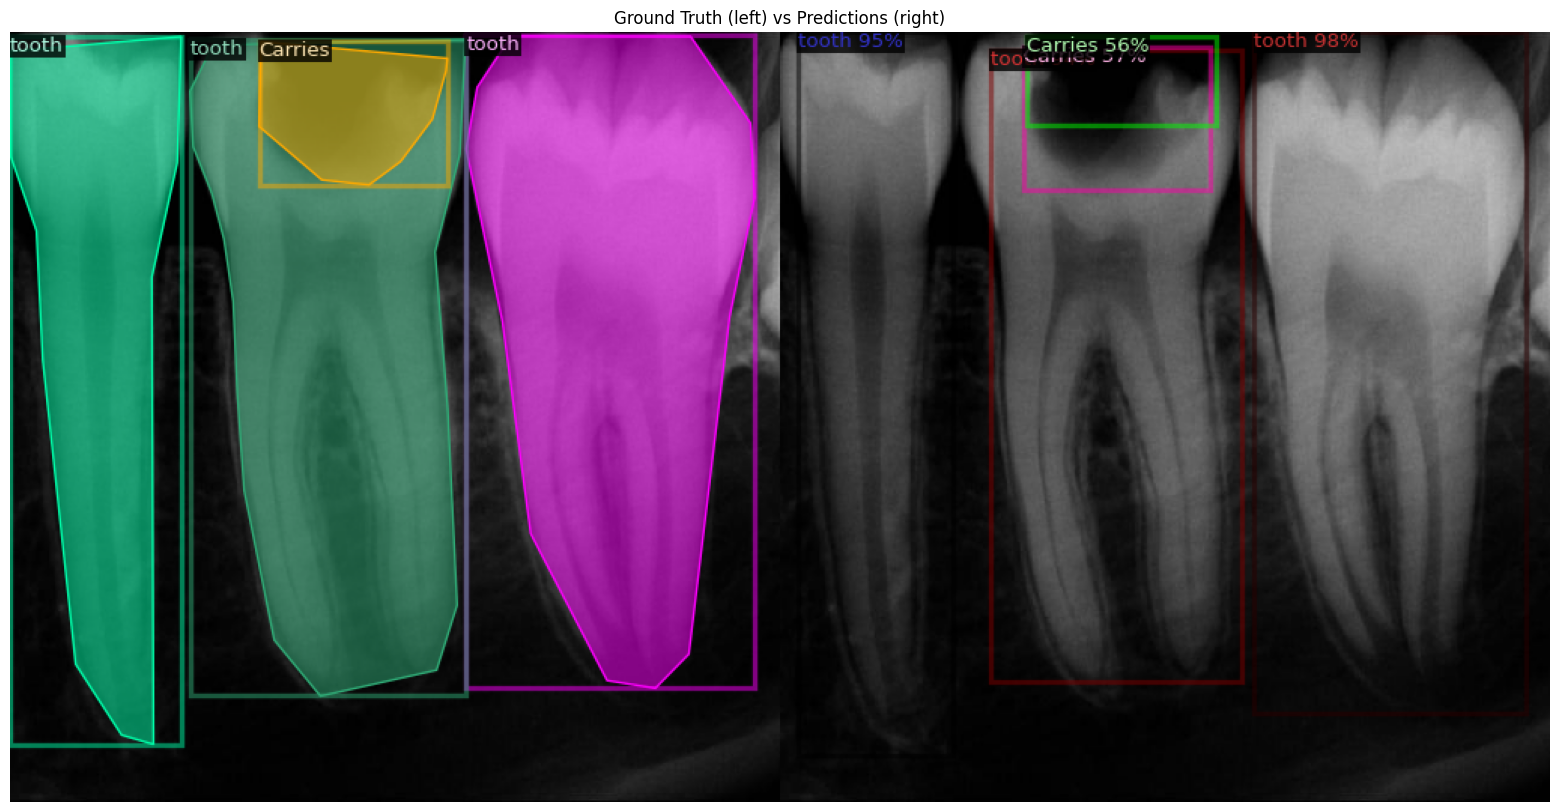


Analyzing class distribution...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Cavities-1/valid/_annotations.coco.json
Loaded 11 images with valid annotations


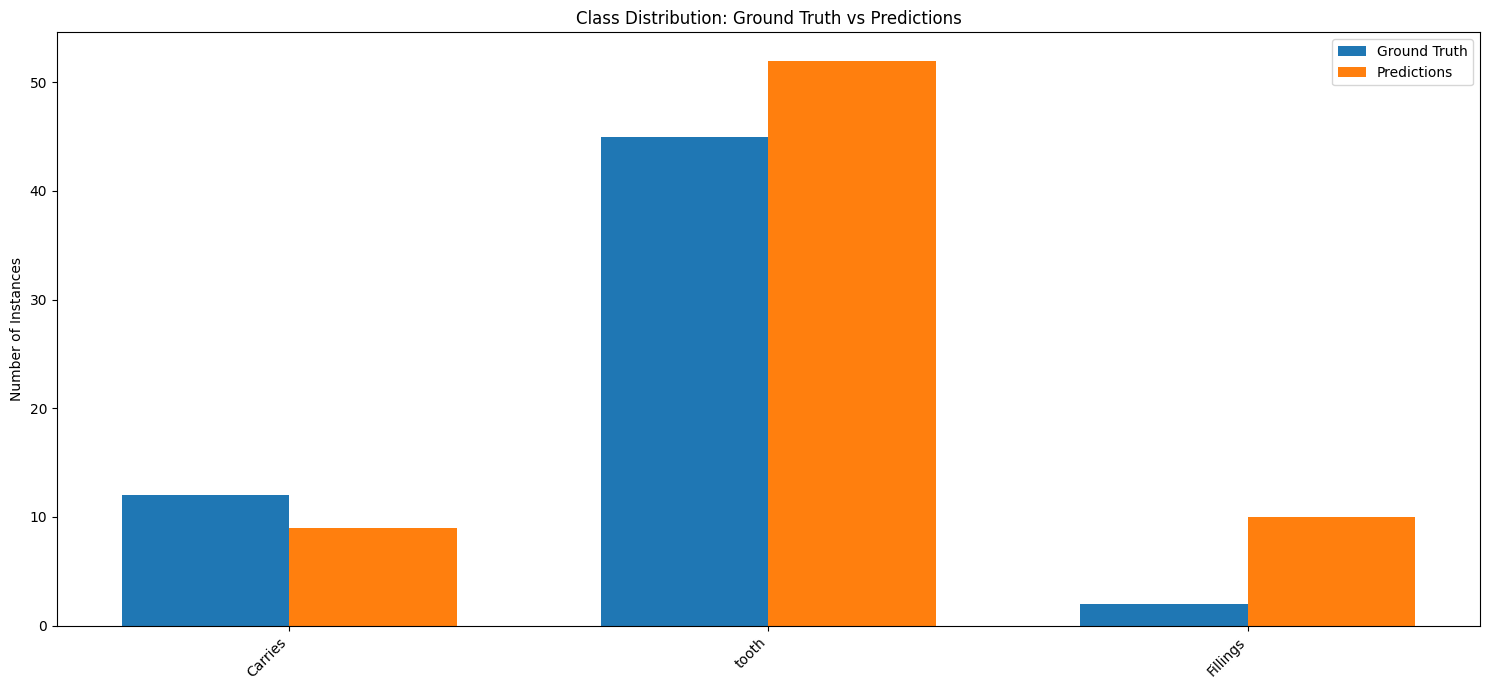


Detection Rates by Class:
--------------------------------------------------
Carries             :  75.00% (9/12)
tooth               : 115.56% (52/45)
Fillings            : 500.00% (10/2)

Generating confusion matrix...
Loading and cleaning annotations from: /home/rayhaan/2024/My Stuff/research projrct/Research_Project/Detectron2/Cavities-1/valid/_annotations.coco.json
Loaded 11 images with valid annotations


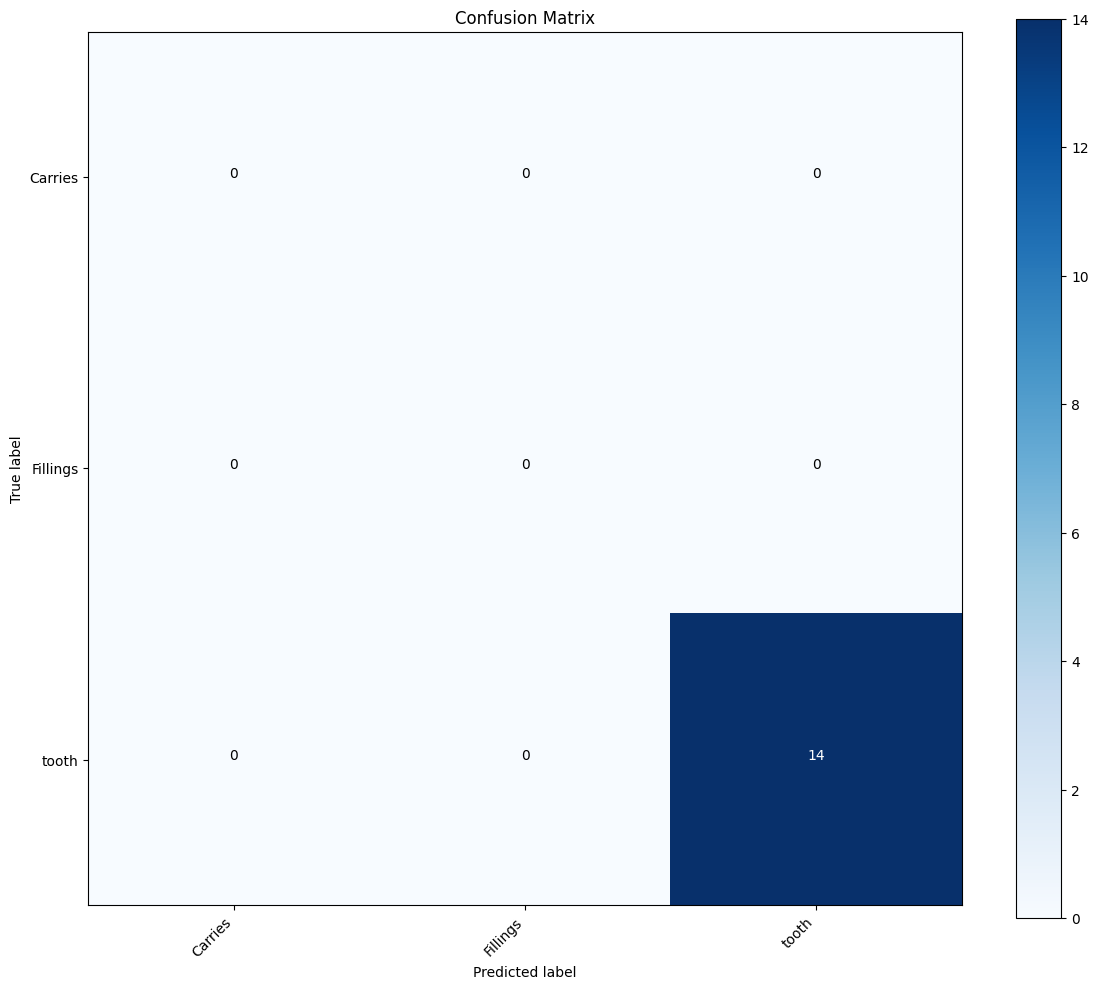

In [68]:
# Main execution
if __name__ == "__main__":
    print("Starting dental cavity detection pipeline...")
    
    try:
        # Step 1: Verify paths
        for path in [TRAIN_DIR, VALID_DIR, TRAIN_JSON, VALID_JSON]:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Path not found: {path}")
        
        # Step 2: Train the model
        print("\nInitiating model training...")
        trainer, cfg = train_model()
        trainer.train()
        
        # Step 3: Create predictor for inference
        cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set testing threshold
        predictor = DefaultPredictor(cfg)
        
        # Step 4: Plot training curves
        print("\nPlotting training curves...")
        plot_training_curves(cfg)
        
        # Step 5: Perform inference visualization
        print("\nVisualizing inference results...")
        perform_inference(cfg, "cavities_val")
        
        # Step 6: Compare ground truth vs predictions
        print("\nComparing ground truth with predictions...")
        compare_ground_truth_and_predictions("cavities_val", predictor)
        
        # Step 7: Analyze class distribution
        print("\nAnalyzing class distribution...")
        analyze_class_distribution("cavities_val", predictor)
        
        # Step 8: Calculate and visualize confusion matrix
        print("\nGenerating confusion matrix...")
        calculate_confusion_matrix("cavities_val", predictor)
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise e